In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.manifold import TSNE

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup
import scipy
from scipy.sparse import coo_matrix, hstack


# Dataset loading

In [3]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

In [4]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [5]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [6]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [7]:
df = pd.DataFrame(dataset2['PTags'].tolist()).stack().value_counts()
#df = df[df>50]
df.shape

(36578,)

In [8]:
existintags = set(df.index)
existintags

{"['css', 'angular', 'web', 'css-frameworks']",
 "['ruby-on-rails', 'shopify']",
 "['reactjs', 'flux']",
 "['java', 'debugging', 'intellij-idea', 'junit', 'kotlin']",
 "['node.js', 'postgresql', 'orm', 'node-postgres', 'objection.js']",
 "['node.js', 'angular', 'npm']",
 "['tensorflow', 'neural-network', 'keras', 'theano', 'feature-extraction']",
 "['d3.js', 'svg']",
 "['heroku', 'rake']",
 "['python', 'pandas', 'data-science', 'pandasql']",
 "['c#', 'xamarin', 'xamarin.forms', 'navigation']",
 "['ruby-on-rails', 'oracle']",
 "['xamarin.forms', 'portable-areas']",
 "['c#', 'google-bigquery']",
 "['ios', 'swift', 'twitter', 'twitter-fabric', 'twitterkit']",
 "['swift', 'double']",
 "['python', 'grpc']",
 "['algorithm', 'complexity-theory', 'fibonacci', 'lower-bound', 'upperbound']",
 "['java', 'selenium', 'selenide']",
 "['reporting-services', 'reportbuilder3.0', 'epicorerp']",
 "['oracle', 'csv', 'export-to-csv', 'sqlplus']",
 "['c#', 'windows', 'command-line', 'parameters']",
 "['bitb

# Dataset splitting

In [9]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

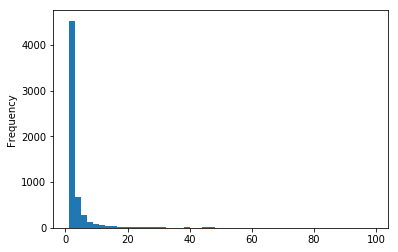

In [10]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()

In [11]:
popularitytags = df[df>50].to_dict()
len(popularitytags)

66

In [12]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(7867, 12)


PTagsCleaned  \
Id                                
48161342              [android]   
48126074         [react-native]   
48130592                    [r]   
48082912  [amazon-web-services]   
48113947                  [php]   

                                                     PTags  \
Id                                                           
48161342                    [android, android-camera, led]   
48126074                                    [react-native]   
48130592                             [r, shiny, shinyapps]   
48082912  [amazon-web-services, amazon-athena, aws-athena]   
48113947                                     [php, pdflib]   

                                                      TCode  
Id                                                           
48161342  Intent intent = new Intent ( this , MainActivi...  
48126074                                               None  
48130592  ui <- fluidPage ( title =" App Title ", dashbo...  
48082912                   WHERE merchant_id ={ merchant_id  
48113947  // to set up a table one needs to supply :/ / ...

In [13]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [14]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(7867, 66)

In [15]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

In [16]:
mlb.classes_

array(['ajax', 'amazon-web-services', 'android', 'angular', 'angularjs',
       'api', 'arrays', 'asp.net', 'asp.net-mvc', 'azure', 'bash', 'c',
       'c#', 'c++', 'css', 'csv', 'database', 'django', 'docker', 'excel',
       'excel-vba', 'express', 'firebase', 'firebase-database', 'git',
       'html', 'ios', 'java', 'javascript', 'jquery', 'json', 'laravel',
       'linux', 'macos', 'mongodb', 'mysql', 'node.js', 'numpy', 'pandas',
       'php', 'postgresql', 'python', 'python-2.7', 'python-3.x', 'r',
       'react-native', 'reactjs', 'regex', 'rest', 'ruby', 'ruby-on-rails',
       'scala', 'spring', 'spring-boot', 'sql', 'sql-server', 'swift',
       'tensorflow', 'twitter-bootstrap', 'typescript', 'vba',
       'visual-studio', 'windows', 'wordpress', 'xcode', 'xml'], dtype=object)

# LDA version

In [17]:

class CustomLDA(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.lda_params = {'n_components':10, 'random_state':0, 'doc_topic_prior':None, 'topic_word_prior':None}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'lda_'+k:v for k,v in self.lda_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #LDA preparation
        self.lda = LatentDirichletAllocation(learning_method = 'batch', **self.lda_params)
        self.lda.fit(Xtrans)
        
        self.components_ = self.lda.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        lda = self.lda.transform(self.transformcvect(X))
        return lda
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.lda_params = {k[4:]:v for k,v in self.params.items() if k.startswith('lda_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.lda_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def perplexity(self, X):
        
        return self.lda.perplexity(self.transformcvect(X))
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]



#customLDA = CustomLDA()


Some docs about the parameters : https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [18]:
topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1),}

customLDA = CustomLDA(**params)
customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [19]:
#Filling rating
customLDA.score()

22.0

In [20]:
#Main topics
customLDA.describe_topics(ntopwords=10, ntopics=20)

array([['function', 'use', 'email', 'argument', 'send', 'name', 'like',
        'creat', 'get', 'code'],
       ['192', '168', 'unknown', '101', 'channel', 'cpp', '_object', 'rpc',
        '9000', 'call'],
       ['compon', 'react', 'use', 'modal', 'angular', 'render', 'nativ',
        'code', 'bootstrap', 'get'],
       ['code', 'use', 'doe', 'get', 'work', 'function', 'compil', 'call',
        'type', 'tri'],
       ['array', 'object', 'valu', 'like', 'number', 'use', 'loop',
        'function', 'return', 'element'],
       ['report', 'crash', 'code', 'locat', 'servlet', 'invok', 'run',
        'add', 'servic', 'sourc'],
       ['start', 'code', 'tri', 'run', 'use', 'dialog', 'press', 'open',
        'activ', 'program'],
       ['scene', 'constraint', 'root', 'background', 'game', 'user', 'get',
        'color', 'code', 'ad'],
       ['row', 'column', 'datafram', 'want', 'attribut', 'valu', 'two',
        'one', 'add', 'tabl'],
       ['connect', 'server', 'ip', 'address', 'socket', 

In [21]:
#Perplexity
customLDA.perplexity(X_test)

10147.917507989434

In [23]:
customLDA.topicsnamed

{0: [],
 1: [],
 2: ['angular'],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: ['rest', 'api'],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: ['php'],
 23: [],
 24: [],
 25: [],
 26: [],
 27: ['typescript'],
 28: ['java'],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: ['api'],
 40: [],
 41: ['xml'],
 42: ['spring'],
 43: [],
 44: [],
 45: ['git'],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: ['html', 'javascript'],
 52: ['docker'],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: ['css'],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: ['python'],
 68: [],
 69: [],
 70: ['sql'],
 71: [],
 72: [],
 73: [],
 74: ['java'],
 75: [],
 76: ['csv'],
 77: ['excel'],
 78: [],
 79: [],
 80: ['android'],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: ['android'],
 89: ['django'],
 90: [],
 91: ['api'],
 92: [],
 93: ['jso

In [24]:
customLDA.namedtopics

{'android': {80, 88},
 'angular': {2},
 'api': {15, 39, 91},
 'css': {60},
 'csv': {76},
 'django': {89},
 'docker': {52},
 'excel': {77},
 'git': {45},
 'html': {51},
 'java': {28, 74},
 'javascript': {51},
 'json': {93},
 'php': {22},
 'python': {67},
 'rest': {15},
 'spring': {42, 98},
 'sql': {70},
 'typescript': {27},
 'xml': {41}}

# TSNE reduction dimension

In [25]:
#customLDA
X_lda = customLDA.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_lda)

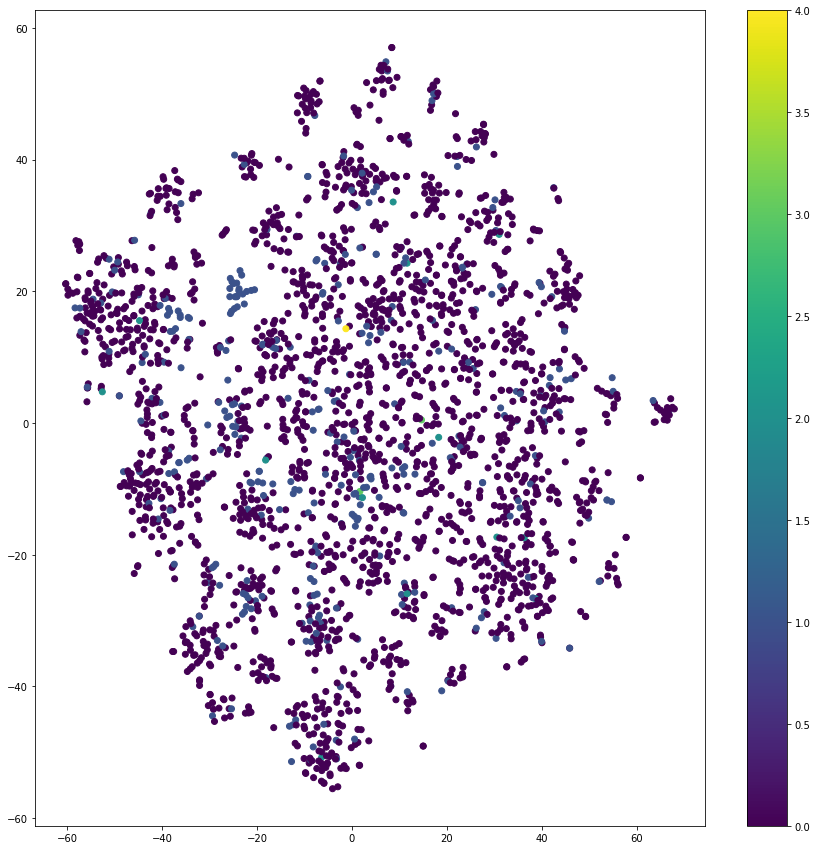

In [26]:
# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_lda, 0)[:, 0]
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

# GridsearchCV LDA

In [27]:
#gridsearch to optimize the parameters - LDA optimization

topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)
}

customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'lda_topic_word_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'clf_merge': [True, False],
             }



clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333, score=23.5, total= 1.4min
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143, score=25.5, total= 1.4min
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.01 
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143, score=15.5, total= 1.5min
[CV] clf_merge=True, lda_

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 10.9min


[CV] clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.0125, score=21.5, total= 1.2min
[CV] clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.0125, score=17.5, total= 1.3min
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666, score=19.0, total= 1.3min
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666, score=17.5, total= 1.4min
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143, score=22.5,

[CV]  clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.008333333333333333, score=12.5, total= 1.3min
[CV]  clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.01, score=13.0, total= 1.2min
[CV] clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.0125 
[CV] clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.0125 
[CV]  clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.01, score=12.5, total= 1.2min
[CV] clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.0125, score=12.0, total= 1.3min
[CV] clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=False, lda_doc_topic_prior=0.008333333333333333, lda_topic_word_prior=0.0125, score=13.5, tota

[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 40.5min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.007142857142857143, 0.008333333333333333, 0.01, 0.0125, 0.016666666666666666], 'lda_topic_word_prior': [0.007142857142857143, 0.008333333333333333, 0.01, 0.0125, 0.016666666666666666], 'clf_merge': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [28]:
clf.best_params_

{'clf_merge': True,
 'lda_doc_topic_prior': 0.016666666666666666,
 'lda_topic_word_prior': 0.007142857142857143}

In [29]:
clf.best_score_

23.0

In [30]:
#Parameters update
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.016666666666666666,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.007142857142857143,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

# Results comparison --> Unsupervised vs Supervised

In [31]:
#Metrics creation

#from sklearn.metrics import fbeta_score
scorer = make_scorer(f1_score, average='micro')


In [32]:
#gridsearch to optimize the parameters - TEXT merged

customLDA = CustomLDA(**params)

parameters = {'vect_1_max_df': [1., 0.9, 0.95],
              'vect_1_max_features': [15000,18000,12000],
              'vect_1_min_df': [1, 10, 20],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.15045439246045103, total= 1.1min
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.12599174865122184, total= 1.3min
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.1455828122494789, total= 1.3min
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.14685770107456853, total= 1.0min
[CV] vect_1_max_df=1.0, vect_1_max_features=18000, vect_1_min_df=1 ...
[

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 10.9min


[CV] vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=1, score=0.1455828122494789, total= 1.3min
[CV] vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=10, score=0.14685770107456853, total= 1.0min
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.15716586151368758, total=  57.9s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.15547815072830906, total= 1.0min
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10, score=0.15045439246045103, total= 1.0min
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed: 22.0min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'],
     lda_doc_topic_prior=0.016666666666666666, lda_n_components=100,
     lda_random_state=0, lda_topic_word_prior=0.007142857142857143,
     vect_1_max_df=1.0, vect_1_max_feature...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.9, 0.95], 'vect_1_max_features': [15000, 18000, 12000], 'vect_1_min_df': [1, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [33]:
clf.best_score_

0.15632200612099831

In [34]:
clf.best_params_

{'vect_1_max_df': 1.0, 'vect_1_max_features': 15000, 'vect_1_min_df': 20}

In [35]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.17225170583775587

In [36]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.016666666666666666,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.007142857142857143,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 20,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

In [37]:
#gridsearch to optimize the parameters - LDA optimization - Final round
customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*0.9), 1/(topics), 1/(topics*0.8), 1/(topics*0.7)],
              'lda_topic_word_prior':[ 1/(topics*1.1), 1/(topics), 1/(topics*0.9), 1/(topics*0.8)],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring = scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01, score=0.1675877520537715, total=  56.3s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909, score=0.15649952091983393, total=  57.1s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909, score=0.16372343609697695, total=  57.7s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topi

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  6.8min


[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.01, score=0.17100484261501211, total=  40.2s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.01, score=0.1486810551558753, total=  39.7s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112, score=0.16634021395208679, total=  39.9s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112, score=0.15421002838221382, total=  40.0s
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.1597074062785736, total=  32.4s
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.14701130856219707, total=  32.3s


[Parallel(n_jobs=3)]: Done  32 out of  32 | elapsed:  8.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'],
     lda_doc_topic_prior=0.016666666666666666, lda_n_components=100,
     lda_random_state=0, lda_topic_word_prior=0.007142857142857143,
     vect_1_max_df=1.0, vect_1_max_feature...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.011111111111111112, 0.01, 0.0125, 0.014285714285714285], 'lda_topic_word_prior': [0.00909090909090909, 0.01, 0.011111111111111112, 0.0125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [38]:
clf.best_score_

0.16283368483168317

In [39]:
clf.best_params_

{'lda_doc_topic_prior': 0.014285714285714285,
 'lda_topic_word_prior': 0.00909090909090909}

In [40]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.18038022813688215

In [41]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.014285714285714285,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.00909090909090909,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 20,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

In [42]:
#Direct calculation

customLDA = CustomLDA(**params)

customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'],
     lda_doc_topic_prior=0.014285714285714285, lda_n_components=100,
     lda_random_state=0, lda_topic_word_prior=0.00909090909090909,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [43]:
customLDA.set_params(clf_popmax=0.14)
customLDA.topic_popularity(X_train)
customLDA.too_popular_topics

[74]

In [44]:
# Topics verification - Too popular
customLDA.describe_topics(ntopwords=20, ntopics=100)[[99]]

array([['file', 'data', 'read', 'csv', 'python', 'use', 'string',
        'extract', 'tri', 'like', 'write', 'ani', 'look', 'want', 'need',
        'way', 'recurs', 'exist', 'would', 'know']],
      dtype='<U12')

In [45]:
# Topics verification - 20 first
customLDA.describe_topics(ntopwords=20, ntopics=20)

array([['duplic', 'step', 'true', 'use', 'remov', 'singl', 'timer', 'one',
        'want', 'appli', 'way', 'like', 'two', 'code', 'special',
        'multipl', 'tri', 'exampl', 'avoid', 'happen'],
       ['generat', 'react', 'token', 'typescript', 'use', 'get', 'js',
        'code', 'auto', 'nativ', 'ok', 'usernam', 'ani', 'follow', 'tri',
        'thank', 'login', 'router', 'librari', 'lib'],
       ['command', 'output', 'program', 'use', 'python', 'file', 'run',
        'bash', 'txt', 'code', 'input', 'would', 'like', 'execut', 'work',
        'normal', 'shell', 'rubi', 'doe', 'get'],
       ['search', 'possibl', 'screen', 'name', 'work', 'setup', 'yes',
        'issu', 'chang', 'thank', 'even', 'part', 'tri', 'box', 'advanc',
        'use', 'come', 'avail', 'help', 'ad'],
       ['group', 'data', 'join', 'column', 'like', 'row', 'combin',
        'report', 'tabl', 'sum', 'want', 'first', 'uniqu', 'index',
        'correspond', 'third', 'use', 'indic', 'problem', 'get'],
       ['val

In [46]:
print(len(customLDA.namedtopics))
customLDA.namedtopics

27


{'ajax': {21},
 'android': {14, 30},
 'angular': {46},
 'api': {14, 45},
 'csv': {99},
 'django': {89},
 'docker': {97},
 'excel': {6},
 'express': {85},
 'git': {18},
 'html': {48, 76},
 'java': {34},
 'javascript': {78},
 'json': {45},
 'laravel': {81},
 'mongodb': {36},
 'mysql': {28},
 'php': {21},
 'python': {2, 71, 99},
 'rest': {45},
 'spring': {79},
 'sql': {28},
 'swift': {86},
 'tensorflow': {82},
 'typescript': {1},
 'wordpress': {41},
 'xml': {21}}

In [47]:
customLDA.topicsnamed

{0: [],
 1: ['typescript'],
 2: ['python'],
 3: [],
 4: [],
 5: [],
 6: ['excel'],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: ['android', 'api'],
 15: [],
 16: [],
 17: [],
 18: ['git'],
 19: [],
 20: [],
 21: ['php', 'xml', 'ajax'],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: ['mysql', 'sql'],
 29: [],
 30: ['android'],
 31: [],
 32: [],
 33: [],
 34: ['java'],
 35: [],
 36: ['mongodb'],
 37: [],
 38: [],
 39: [],
 40: [],
 41: ['wordpress'],
 42: [],
 43: [],
 44: [],
 45: ['json', 'api', 'rest'],
 46: ['angular'],
 47: [],
 48: ['html'],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: ['python'],
 72: [],
 73: [],
 74: [],
 75: [],
 76: ['html'],
 77: [],
 78: ['javascript'],
 79: ['spring'],
 80: [],
 81: ['laravel'],
 82: ['tensorflow'],
 83: [],
 84: [],
 85: ['express'],
 86: ['swift'],
 87

In [48]:
mlb.inverse_transform(y_test[:10])

[('django',),
 ('database', 'django', 'python'),
 ('java',),
 ('angular', 'typescript'),
 ('python', 'python-3.x'),
 ('ruby-on-rails',),
 ('arrays', 'javascript', 'postgresql', 'reactjs'),
 ('ios', 'xcode'),
 ('php',),
 ('scala',)]

In [49]:
customLDA.predict_word(X_test[:10])

array([['result', 'queri', 'get', 'return', 'use', 'collect', 'field',
        'design', 'member', 'use', 'command', 'output', 'program', 'use',
        'python'],
       ['duplic', 'step', 'true', 'use', 'remov', 'data', 'set', 'use',
        'model', 'clear', 'number', 'count', 'link', 'want', 'background'],
       ['modul', 'locat', 'check', 'checkbox', 'work', 'command', 'output',
        'program', 'use', 'python', 'map', 'compil', 'tensorflow', 'std',
        'get'],
       ['button', 'click', 'add', 'sort', 'input', 'header', 'option',
        'account', 'origin', 'set', 'compon', 'event', 'remov', 'move',
        'want'],
       ['error', 'get', 'tri', 'code', 'follow', 'duplic', 'step', 'true',
        'use', 'remov', 'second', 'first', 'delet', 'two', 'one'],
       ['state', 'id', 'job', 'compon', 'share', 'instanc', 'authent',
        'default', 'use', 'employe', 'like', 'use', 'way', 'statement',
        'would'],
       ['display', 'html', 'tag', 'format', 'use', 'imag', 

In [50]:
mlb.inverse_transform(customLDA.predict(X_test[:10]))

[('python',),
 (),
 ('python', 'tensorflow'),
 (),
 (),
 (),
 ('html',),
 (),
 (),
 ('api', 'json', 'rest')]

In [51]:
predict = mlb.inverse_transform(customLDA.predict(X_test))
truetag = mlb.inverse_transform(y_test)

for prediction, tags, post in zip(predict, truetag, list(X_test['TText'])):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print()

'm get incorrect output queri set use request.method == post selectedaccesslevel == show queryset s00009 's written databas believ use get sinc 'm expect one valu filter get coid owner.coid.coid provid valu level 'm look output datareducecod s00009 queryset s00009 accomplish view

TRUE --> ('django',)
PRED --> ('python',)

use python django want remov duplic data field ‘ agent__id ’ account count field agent__id data code follow data follow code print follow want data follow

TRUE --> ('database', 'django', 'python')
PRED --> ()

tri generat ikm deriv tabl statement sourc command abl set sourc command abl check check box `` deriv tabl statement '' shown pictur code tri

TRUE --> ('java',)
PRED --> ('python', 'tensorflow')

strang behavior updat angular compon variabl anoth component.can somebodi tell whi happen someth bad two compon header.compon home.compon ngoninit home.compon call api share respons header.compon updat valu header.component.html home.component.t header.component.t ex

use program predict handwritten imag predict number use previous train data follow program pleas help out.im new code use imag process code fragment use variabl alreadi train save restor imag file use

TRUE --> ('python-3.x',)
PRED --> ()

python project scheduel task specif time like `` execut cat everi month 1pm03 '' command take entri minut hour day month n't find ani answer handl proper schedul without use someth like schedul librari ani extern librari ani advic thank

TRUE --> ('python',)
PRED --> ('python',)

'm troubl guy hope help tinymc work absolut fine save databas problem tri retriev use noth show print data databas back textarea tag tinymc way design redesign edit.blade.php tinymc script pardon bad english thank guy

TRUE --> ('javascript', 'mysql')
PRED --> ('ajax', 'html', 'php', 'xml')

'm tri figur display onli origin tweet code part witch suppos display onli origin post wo n't work correct ani idea 's wrong differenti origin tweet

TRUE --> ('python',)
PRED --> ('html


aim websit page let 's call `` random question '' time user enter page set number random generat correct answer question numbera number b correct go page say `` correct '' redirect back page differ set number issu first page `` random question `` want add anoth question views.pi see right onli doe one simpl style question addit onli question would like add anoth question question could someth like `` '' someth like abov would achiev use someth like java switch statement sure django though possibl without random number would generat correspond anoth question 'd use anoth statement request.method == post calcul correct answer new question would calcul differ abov would good strategi short term long term sure ideal better way sort thing way ok think way includ ** ani perform consider awar ** updat ok gone ahead implement suggest abov happen django view get call -- anoth view function random call doe process return context object good practic style continu way

TRUE --> ('django', 'python

PRED --> ('html', 'wordpress')

titl suggest 'm go illustr minimum need reproduc situat got fakeviewcontrol embed navig control contain cell must occupi entir collectionview bound like pageviewcontrol display simpl viewcontroller.view light blue one pictur viewdidload everyth fine tap searchbar navig bar disappear either top view collectionview move tap cancel button cell remain bit top view hide part content consol print look debug view hierarchi found collectionview right frame cell doe n't updat n't forc cell turn shorter tri whit custom uicollectionviewflowlayout call invalidatelayout cancel tap happen problem persist edit forgot say topview `` requir '' issu fakeviewcontrolelr implement thank advanc ani help kind regard alessandro

TRUE --> ('ios', 'swift')
PRED --> ('excel',)

'm tri find line tabl _context.tables_not use valu datagridview match select cell/row datagridview datasourc anoth tabl _context.t line found use get databind textbox select cell/row textbox content chang f

PRED --> ()

current default health bar uniti use default imag rectangl use simpl code creat health bar imag want fill want fill inner part imag wrong want would awesom someon could provid small introduct

TRUE --> ('c#',)
PRED --> ()

browser show mani redirect connect base_url exampl enter `` www.xxx.com '' codeingit show error mani redirect enter `` www.xxx.com/login '' show login control page happen me.. want see default control dose n't work codeignit config sourc end codeignit rout sourc end codeignit login control sourc last .htaccess sourc n't understand whi default_control doe n't work refer thanks..

TRUE --> ('php',)
PRED --> ('tensorflow',)

code allow search file path multipl subfold open file howev want abl open multipl file slight differ name e.g effect00001.dat effect00014.dat howev 'm sure code

TRUE --> ('excel', 'excel-vba', 'vba')
PRED --> ('csv', 'python')

'm work first symfony-bas applic want use `` trusted_host '' option make app littl secur start develop use sy

TRUE --> ('node.js', 'reactjs')
PRED --> ('docker',)

suppos model properti omit obvious show varieti product productmerg inlin insid admin panel tri set custom get_queryset tabularinlin get follow except valueerror marketplace.varieti foreignkey marketplace.productmerg

TRUE --> ('django', 'python')
PRED --> ('javascript',)

tri use pdfminer.six convert multipl pdfs directori multipl .txt file use python 3.6.3 got error modulenotfounderror modul name pdfminer run code run pdf2txt.pi filename.pdf give therenv python\r file directori research regard issu remov origin pdfminer pip current onli pdfminer.six pip also run python 3.6.3 virtualenv code run

TRUE --> ('python', 'python-3.x')
PRED --> ('csv', 'python')

hello happi new year everybodi came across weird behaviour panda tri manual encod label would awesom anybodi could explain whi happen code problem label embark variabl test data doe get overwritten get instead littl bit experiment found line uniqu df_train col .uniqu reason whi 

TRUE --> ('sql',)
PRED --> ('csv', 'python')

use selenium webdriv locat text webpag use text 's xpath two separ condit want look span tag class correct'and span tag parent label li tag class answer_correct answer_correct element correct element far xpath come think return list webel criteria code return list element expect code return list element expect howev tri xpath creat merg two return web element first path befor return onli list answer_correct revers order return onli correct element lead believ someth wrong statement correct way merg two separ xpath one append one list onto anoth order element import

TRUE --> ('python',)
PRED --> ()

'm tri figur proper way manag user webapi use ident server token server start authent user like want central place store inform current log user link id databas first intuit make usermanag handl get claimsident custom claim userid rememb asp.net ident iusermanag start question whether use built mechan confus proper way architect need abl track c


TRUE --> ('javascript',)
PRED --> ('django',)

got problem dialer devic model n't test problem phone number format reasion dialer replac screenshot user bug

TRUE --> ('android',)
PRED --> ('django',)

follow code follow except get except thread `` main '' org.openqa.selenium.elementnotvisibleexcept element visibl element current visibl may manipul

TRUE --> ('java',)
PRED --> ()

thread write vector 's possibl differ thread tri write byte read use onli atomic_fecth_or like exampl vector becom thread safe compil gcc without error warn

TRUE --> ('c++',)
PRED --> ('csv', 'python')

notic rxswift slow app n't know fault framework bind insid custom class uicollectionviewcel fire configur cell exampl part code observableishighlight observableismark behaviorrelay bool take around 16-20 millisecond unaccept uicollectionview cours anoth part like take around millisecond question someth wrong approach bind rxswift accur view like uicollectionview cours assum bind rxswift exact thing like uico

code app tri download apk webspac googl whole day everyth found java think need c problem code ca n't use setrequestmethod getinputstream etc tri becaus seem much easier also work 'm get messag `` part path found '' kinda like visual studio n't english doe n't matter enter path

TRUE --> ('android', 'c#')
PRED --> ()

angular applic would like overrid default valid behaviour form input particular 'd like immedi trigger field valid soon user insert someth current default behaviour follow assum exampl valid allow onli integ initi field pristin empti user focus input enter data despit insert valu valid becaus 's integ valid trigger yet trigger soon user leav focus exampl press tab focus anoth input valid trigger everi chang user goe back field insert valid valu valid immedi job would like make valid mark field invalid soon non valid data insert even user insert data first time never left field yet

TRUE --> ('angular',)
PRED --> ('javascript',)

possibl take specif part code one php file 

's comment code attempt mine solv problem

TRUE --> ('c#',)
PRED --> ()

chat applic user get creat user login applic want delet user use rest api per document curl request delet user generat qb-token thank advanc

TRUE --> ('javascript', 'php')
PRED --> ('laravel', 'typescript')

tri open disconnect recordset c++ use ado sql server code run code close anyth leav connect open work correct tri disconnect recordset use putrefactiveconnect close connect object per ms exampl get error oper allow open connect tri clone record set throw also tri execut putrefactiveconnect close also tri dyman cursor tri read onli lock optimist pessimist lock anyon ani suggest connect string provider=sqlncli11 data source=gcsql\gfdb datatypecompatibility=80 initi catalog=gf_trad trusted_connection=y code

TRUE --> ('c++',)
PRED --> ()

like lot non-greenfeild project arriv new job find test perform use featur spec controller/model spec natur mean test take realli long time execut way setup rspec featur test r

# NMF version

In [52]:

class CustomNMF(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.nmf_params = {'n_components':10, 'random_state':0, 'init':'nndsvd', 'alpha':.05, 'l1_ratio':0}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'nmf_'+k:v for k,v in self.nmf_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #NMF preparation
        self.nmf = NMF(**self.nmf_params)
        self.nmf.fit(Xtrans)
        
        self.components_ = self.nmf.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        nmf = self.nmf.transform(self.transformcvect(X))
        return nmf
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.nmf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('nmf_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.nmf_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5 #self.nmf_params['n_components']//10
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]
        

#customNMF = CustomNMF()



In [53]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

customNMF = CustomNMF(**params)
customNMF.fit(X_train, y_train)

CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=5, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1))

In [54]:
#Topic popularity
customNMF.topic_pop_

{0: 1398,
 1: 172,
 2: 204,
 3: 137,
 4: 740,
 5: 225,
 6: 229,
 7: 88,
 8: 71,
 9: 174,
 10: 278,
 11: 127,
 12: 247,
 13: 152,
 14: 12,
 15: 48,
 16: 187,
 17: 128,
 18: 144,
 19: 210,
 20: 145,
 21: 220,
 22: 104,
 23: 132,
 24: 160,
 25: 171,
 26: 127,
 27: 143,
 28: 58,
 29: 174,
 30: 48,
 31: 135,
 32: 123,
 33: 135,
 34: 121,
 35: 103,
 36: 171,
 37: 73,
 38: 127,
 39: 389,
 40: 119,
 41: 198,
 42: 252,
 43: 295,
 44: 141,
 45: 85,
 46: 561,
 47: 60,
 48: 223,
 49: 264,
 50: 98,
 51: 230,
 52: 157,
 53: 227,
 54: 134,
 55: 377,
 56: 258,
 57: 115,
 58: 228,
 59: 271,
 60: 236,
 61: 344,
 62: 192,
 63: 179,
 64: 172,
 65: 380,
 66: 245,
 67: 652,
 68: 198,
 69: 263,
 70: 261,
 71: 205,
 72: 308,
 73: 427,
 74: 285,
 75: 359,
 76: 316,
 77: 732,
 78: 278,
 79: 527,
 80: 414,
 81: 209,
 82: 180,
 83: 223,
 84: 471,
 85: 263,
 86: 227,
 87: 417,
 88: 353,
 89: 324,
 90: 210,
 91: 360,
 92: 213,
 93: 321,
 94: 333,
 95: 279,
 96: 402,
 97: 384,
 98: 440,
 99: 1645}

In [55]:
#Topics over represented in our set
customNMF.too_popular_topics

[99, 0]

In [56]:
customNMF.score()

28.666666666666664

In [57]:
#Topic description : number --> Name
customNMF.topicsnamed

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: ['mongodb'],
 7: [],
 8: ['sql', 'mongodb', 'mysql'],
 9: ['sql'],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: ['regex'],
 20: [],
 21: ['django'],
 22: [],
 23: [],
 24: [],
 25: ['ajax'],
 26: [],
 27: ['mysql'],
 28: [],
 29: ['php', 'laravel', 'ajax'],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: ['bash'],
 37: [],
 38: ['json'],
 39: [],
 40: [],
 41: ['java', 'xml'],
 42: ['ajax'],
 43: ['git'],
 44: [],
 45: [],
 46: [],
 47: ['python'],
 48: [],
 49: [],
 50: ['api', 'rest'],
 51: [],
 52: ['mysql'],
 53: [],
 54: ['express'],
 55: [],
 56: [],
 57: ['javascript', 'css'],
 58: [],
 59: [],
 60: ['android'],
 61: ['html', 'angular'],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: ['docker'],
 69: ['django', 'tensorflow'],
 70: ['css'],
 71: [],
 72: [],
 73: [],
 74: [],
 75: ['sql'],
 76: [],
 77: [],
 78: ['git'],
 79: [],
 80: [],
 81: ['excel', 'vba'],
 82:

In [58]:
print(len(customNMF.namedtopics))
customNMF.namedtopics

28


{'ajax': {25, 29, 42},
 'android': {60},
 'angular': {61},
 'api': {50},
 'bash': {36, 98},
 'css': {57, 70, 88},
 'csv': {82},
 'django': {21, 69},
 'docker': {68},
 'excel': {81},
 'express': {54},
 'git': {43, 78},
 'html': {61},
 'java': {41},
 'javascript': {57},
 'json': {38},
 'laravel': {29, 89},
 'mongodb': {6, 8},
 'mysql': {8, 27, 52},
 'php': {29},
 'python': {47},
 'regex': {19},
 'rest': {50},
 'spring': {86},
 'sql': {8, 9, 75, 97},
 'tensorflow': {69},
 'vba': {81},
 'xml': {41, 91}}

In [59]:
# Topics verification
customNMF.describe_topics(ntopwords=20, ntopics=100)[[17]]

array([['test', 'unit', 'mock', 'case', 'jest', 'junit', 'fail', 'assert',
        'paramet', 'karma', 'first', 'inject', 'simpl', 'nunit', 'write',
        'jenkin', 'rout', 'timeout', 'might', 'integr']],
      dtype='<U16')

In [60]:
#customNMF
X_mnf = customNMF.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_mnf)

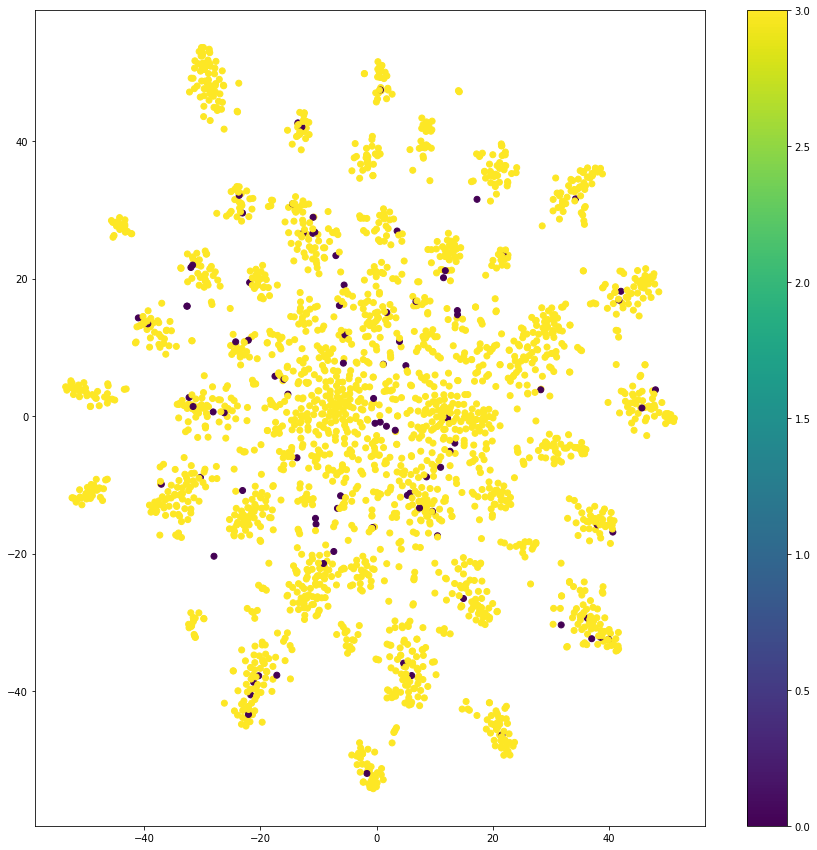

In [61]:
# plot the result according the topics
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_mnf, 0)[:, 3] ## Change the topic number here
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

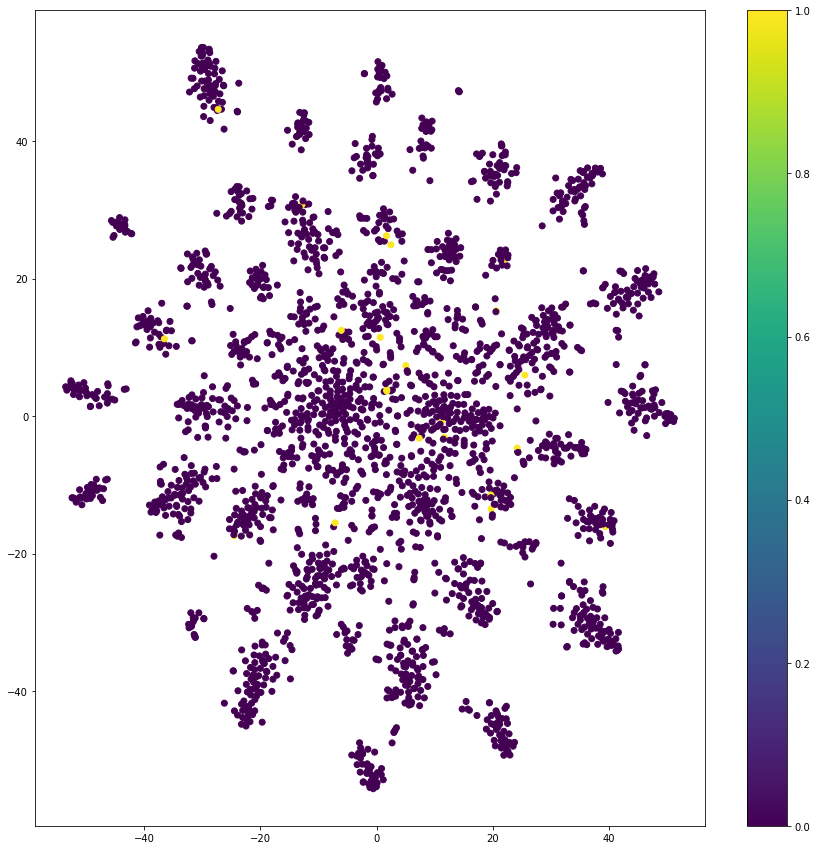

In [62]:
# plot the result according the labels
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = y_test[:, 21]  ## Change the tag position here
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

In [63]:
predict = mlb.inverse_transform(customNMF.predict(X_test))
truetag = mlb.inverse_transform(y_test)
wordtag = customNMF.predict_word(X_test)

for prediction, tags, post, keywords in zip(predict, truetag, list(X_test['TText']), wordtag):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('KEYW --> {}'.format(keywords))
    print('--------------------------------------------')

'm get incorrect output queri set use request.method == post selectedaccesslevel == show queryset s00009 's written databas believ use get sinc 'm expect one valu filter get coid owner.coid.coid provid valu level 'm look output datareducecod s00009 queryset s00009 accomplish view

TRUE --> ('django',)
PRED --> ()
KEYW --> ['print' 'output' 'loop' 'consol' 'charact' 'post' 'request' 'bodi' 'http'
 'header' 'get' 'tri' 'follow' 'ca' 'figur']
--------------------------------------------
use python django want remov duplic data field ‘ agent__id ’ account count field agent__id data code follow data follow code print follow want data follow

TRUE --> ('database', 'django', 'python')
PRED --> ('mongodb',)
KEYW --> ['field' 'input' 'valid' 'focus' 'dynam' 'number' 'count' 'sort' 'random'
 'phone' 'data' 'frame' 'fetch' 'chart' 'mongodb']
--------------------------------------------
tri generat ikm deriv tabl statement sourc command abl set sourc command abl check check box `` deriv tabl state


TRUE --> ('python',)
PRED --> ('excel', 'vba')
KEYW --> ['cell' 'excel' 'formula' 'vba' 'sheet' 'help' 'ani' 'thank' 'appreci'
 'pleas' 'work' 'doe' 'whi' 'fine' 'tri']
--------------------------------------------
use git add print use run open window pro ask open anoth program last time say open virtual machin 8210b_xxxx forgot 's number x 's wrong

TRUE --> ('git',)
PRED --> ()
KEYW --> ['open' 'link' 'close' 'window' 'click' 'print' 'output' 'loop' 'consol'
 'charact' 'number' 'count' 'sort' 'random' 'phone']
--------------------------------------------
'm current struggl xaxi format.. date doesnt start somewher year someth done wrong tick label like thu 01.06.2017 fri 02.06.2017 etc datafram look like

TRUE --> ('pandas', 'python')
PRED --> ()
KEYW --> ['datafram' 'panda' 'df' 'origin' 'index' 'date' '01' 'format' 'year'
 'rang' 'like' 'would' 'look' 'someth' 'way']
--------------------------------------------
one applic use web api site onli consum asmx web servic recent deploy w

--------------------------------------------
im code websit want headers..on show user top page second one scroll tri jqueri work like suppos top page `` top '' scroll `` top2 '' scroll back top second one 's suppos fade filckers/blink one time fade html css

TRUE --> ('css', 'html', 'jquery')
PRED --> ('ajax',)
KEYW --> ['scroll' 'horizont' 'top' 'content' 'height' 'one' 'two' 'differ' 'second'
 'first' 'page' 'redirect' 'login' 'section' 'ajax']
--------------------------------------------
'm fetch data mysql db use php backend angular frontend use queri fetch data receiv client side data json re-arrang accord first column asc order forc client side receiv data order sent receiv data

TRUE --> ('angular', 'json', 'mysql', 'php')
PRED --> ('mongodb', 'sql')
KEYW --> ['data' 'frame' 'fetch' 'chart' 'mongodb' 'server' 'client' 'sql' 'socket'
 'send' 'email' 'send' 'notif' 'event' 'address']
--------------------------------------------
develop angular applic bellow part common multipl co

KEYW --> ['custom' 'want' 'theme' 'listview' 'categori' 'help' 'ani' 'thank'
 'appreci' 'pleas' 'model' 'django' 'train' 'tensorflow' 'product']
--------------------------------------------
two comput two gpus tri start distribut tensorflow veri confus work comput would like one ps task impress go cpu two worker task one per gpu would like two worker task comput b 's tri implement test.pi find run python3 test.pi -- job_nam ps == task_idx comput see gpus comput immedi reserv script comput b show activ expect thought sinc ps job simpli run server.join use gpu howev see set pdb break point soon server initi gpus taken leav sever question whi doe server immedi take gpu capac suppos alloc gpu launch differ process doe origin plan even make sens still littl confus task vs. cluster vs. server etc watch tensorflow develop summit video distribut tensorflow also look around github blog abl find work code exampl use latest even relat recent distribut tensorflow function likewis notic mani questi

TRUE --> ('php',)
PRED --> ('ajax',)
KEYW --> ['form' 'submit' 'valid' 'upload' 'ajax' 'field' 'input' 'valid' 'focus'
 'dynam' 'one' 'two' 'differ' 'second' 'first']
--------------------------------------------
app throw error wonder someon could help use box softwar system write app thing system app work 's 's call store procedur take max key add one use new key insert line tabl adjust inventori match anoth tabl ix_inventoryadjustments_3 index say uniqu non-clust correct number duplic tabl 'm confus doe anyon know chang index box softwar n't think chang tri use crazi high key still get error n't know make index key match tabl key know test becaus key 999,999 make complic 's ad max 's 's come 1,000,002 field length char wonder someth 's insert item becaus one alreadi whi work chang +4 work first one second one error say duplic key 1,000,003 n't higher becaus ad +1 +4 's increment four select max adjustmentno inventoryadjust still get 999,999 odd thing app still work doe n't insert adj

generic compon invok appli mask target element add input put focus work perfect fine even mobil devic input display keyboard roll user write someth without ani addit action work one case redirect case look like put focus input action taken user particular view would need somehow forc js click input doe n't seem work neither

TRUE --> ('javascript', 'jquery')
PRED --> ('css',)
KEYW --> ['field' 'input' 'valid' 'focus' 'dynam' 'work' 'doe' 'whi' 'fine' 'tri'
 'display' 'month' 'tooltip' 'safari' 'css']
--------------------------------------------
develop applic use spring boot 1.5.9.releas use gradl build tool want use selenumhq 3.8.1 project build project notic selenium 2.53.1 ad project 3.8.1 investig found reason exist follow statement build.gradl file selenium.vers properti set 2.53.1 chang statement idea show 3.8.1 2.53.1 depend project build artifact use gradl onli exist 2.53.1 depend sign 3.8.1 chang behavior use selenium 3.8.1 p.s selenium made multipl jar file singl jar file wan

--------------------------------------------
php applic need execut routin mssql use sqlsrv driver develop solut use ajax monitor execut keep user updat progress current 's implement store procedur php execut stay block time except thrown need php execut immedi return leav sp run ani option allow sqlsrv_queri anoth function execut asynchron

TRUE --> ('php', 'sql-server')
PRED --> ('ajax', 'bash', 'laravel', 'php', 'sql')
KEYW --> ['store' 'procedur' 'sql' 'order' 'set' 'command' 'execut' 'follow' 'bash'
 'process' 'php' 'laravel' 'xampp' 'echo' 'ajax']
--------------------------------------------
code work fine entiti framework 1.0 could also 1.1 entiti framework core 2.0 got except error quick fix would way track disabl defeat purpos asnotrack method regard offici recommend els would updat pupil properti come client

TRUE --> ('c#',)
PRED --> ('git',)
KEYW --> ['properti' 'undefin' 'read' 'null' 'typeerror' 'chang' 'color' 'style'
 'background' 'git' 'work' 'doe' 'whi' 'fine' 'tri']


PRED --> ()
KEYW --> ['save' 'session' 'token' 'storag' 'pdf' 'file' 'upload' 'folder'
 'download' 'path' 'help' 'ani' 'thank' 'appreci' 'pleas']
--------------------------------------------
mvc project uknown reason refus publish local folder pc log say follow n't problem debug either releas debug config

TRUE --> ('asp.net', 'asp.net-mvc', 'c#', 'visual-studio')
PRED --> ('git',)
KEYW --> ['project' 'build' 'depend' 'librari' 'folder' 'log' 'login' 'console'
 'consol' 'git' 'applic' 'web' 'net' 'asp' 'azur']
--------------------------------------------
unabl add filter web.xml eclips mar error -server apache-tomcat-8.0.35 localhost fail start .the server use tomcat-8.0.35 ani kind chang web.xml result error -server apache-tomcat-8.0.35 localhost fail start messag shown consol window

TRUE --> ('java',)
PRED --> ('sql', 'xml')
KEYW --> ['server' 'client' 'sql' 'socket' 'send' 'activ' 'fragment' 'xml' 'layout'
 'screen' 'applic' 'web' 'net' 'asp' 'azur']
-------------------------------

TRUE --> ('html', 'jquery')
PRED --> ('angular', 'html')
KEYW --> ['html' 'angular' 'js' 'tag' 'index' 'one' 'two' 'differ' 'second' 'first'
 'button' 'click' 'radio' 'press' 'event']
--------------------------------------------
develop cordova app notic white screen splash screen befor html page ani solut get rid white screen face issu iphon app use cordova helloworld app issu relat plugin cordova v7.0.1

TRUE --> ('javascript',)
PRED --> ('android', 'xml')
KEYW --> ['app' 'io' 'background' 'rout' 'devic' 'activ' 'fragment' 'xml' 'layout'
 'screen' 'android' 'devic' 'cordova' 'build' 'studio']
--------------------------------------------
creat angular product build follow command howev generat file dist folder exampl main.0c05c6d4245461043e3f.bundl block csp thus make appli style show error retriev refus appli inlin style becaus violat follow content secur polici direct check compon n't find ani inlin call css style mayb becaus third-parti plugin els howev also want appli hash nonc ac

place spinner insid tablerow tablelayout spinner dropdown icon visibl tabl place spinner insid tabl row spinner dropdown arrow visibl insid tabl row tabl place spinner insid relat layout insid tabl row scenario also spinner drop visibl ui screen spinner width exceed relat layout fix spinner fix width drop icon visibl 's wrong code style.xml

TRUE --> ('android',)
PRED --> ('css', 'sql', 'xml')
KEYW --> ['div' 'css' 'posit' 'tag' 'right' 'activ' 'fragment' 'xml' 'layout'
 'screen' 'tabl' 'join' 'sql' 'insert' 'record']
--------------------------------------------
given 'm get differ object result depend api queri two exampl implement want build map variabl array access object easili let 's assum content first exampl object work second exampl object doe done stuck statement

TRUE --> ('php',)
PRED --> ()
KEYW --> ['object' 'iter' 'game' 'refer' 'nest' 'properti' 'undefin' 'read' 'null'
 'typeerror' 'one' 'two' 'differ' 'second' 'first']
--------------------------------------------
call j

 'order' 'set' 'valu' 'textbox' 'find' 'rang' 'insert']
--------------------------------------------
object anoth object want check obj2 valu includ obj1 tri method return fals abov two object wrong

TRUE --> ('javascript', 'node.js')
PRED --> ()
KEYW --> ['object' 'iter' 'game' 'refer' 'nest' 'return' 'respons' 'true' 'null'
 'alway' 'call' 'method' 'pass' 'thread' 'paramet']
--------------------------------------------
first two code sampl two sampl appear essenti ident one use whi

TRUE --> ('c#',)
PRED --> ()
KEYW --> ['one' 'two' 'differ' 'second' 'first' 'use' 'way' 'tri' 'follow' 'without'
 'class' 'constructor' 'static' 'inherit' 'extend']
--------------------------------------------
much familiar angularjs+blad templat mix blade templat laravel render ng-includ angularj html file necessari convert includ html blade file well core php issu could way work situat non ng-includ load blade templat use angular ng-includ blade

TRUE --> ('angularjs', 'laravel')
PRED --> ('angular', '

PRED --> ()
KEYW --> ['help' 'ani' 'thank' 'appreci' 'pleas' 'instal' 'npm' 'window' 'packag'
 'pip' 'type' 'generic' 'convert' 'paramet' 'compil']
--------------------------------------------
'm tri login websit use python mechan websit login form insid frame like 'm abl get login form go note n't want direct open link http //example.com/login.htm via get insid frame onli

TRUE --> ('python',)
PRED --> ('ajax', 'git')
KEYW --> ['form' 'submit' 'valid' 'upload' 'ajax' 'log' 'login' 'console' 'consol'
 'git' 'open' 'link' 'close' 'window' 'click']
--------------------------------------------
databas differ function procedur view throw timeout except applic even ssms script veri slow problem onli occur earli morn 7am 9am especi monday morn script veri short afternoon durat one second session run slow block ani session schedul agent job run dure time also run afternoon sinc view also affect paramet snif ani problem queri plan idea caus fluctuat one affect view look like default durat quer


TRUE --> ('mysql', 'php')
PRED --> ('bash', 'sql')
KEYW --> ['command' 'execut' 'follow' 'bash' 'process' 'store' 'procedur' 'sql'
 'order' 'set' 'select' 'option' 'dropdown' 'want' 'grid']
--------------------------------------------
use netbean 8.2 spring boot maven 4.0 tomcat 8.5 pom file generat class webservic applic servlet webservic oper run deploy tomcat server port call localhost:8090/demo-sem-d get whitelabel error page unexpect error type=not found status=404 messag avail n't know 's relat also get info messag tomcat log run applic say org.apache.catalina.core.applicationcontext.log spring webapplicationiniti detect classpath search internet main stackoverflow tri find definit answer far n't ani luck would grate anyon help pleas let know anyth extra add question thank

TRUE --> ('spring-boot',)
PRED --> ('git', 'spring')
KEYW --> ['spring' 'boot' 'bean' 'configur' 'autowir' 'log' 'login' 'console'
 'consol' 'git' 'help' 'ani' 'thank' 'appreci' 'pleas']
---------------------

--------------------------------------------
want display item class div-contain code look like two row item problem second row div-contain shift get display wrong first pictur second row big gap empti div goe pictur help solv im total beginn pleas lot explain

TRUE --> ('asp.net-mvc',)
PRED --> ('css',)
KEYW --> ['div' 'css' 'posit' 'tag' 'right' 'display' 'month' 'tooltip' 'safari'
 'css' 'row' 'delet' 'grid' 'add' 'dynam']
--------------------------------------------
custom implement inputstream current updat multipl messagedigest- read data allow singl read process data avoid re-read file order calcul checksum quit effici save time implement follow-up step would like use apach tika guess file extens stream sent http know suggest simpli set content-typ header requir 's set unfortun various reason reli enforc henc 'm look way guess extens base inputstream 's sent also need abl guess complex extens type tar.gz tar.bz2 similar one n't easi guess substr last index dot end string most-ef

In [64]:
params = {'clf_ntopics': 3,
 'clf_ntopwords': 10,
 'clf_merge':True,
 'clf_serie':['TText', 'TTitle'],
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'nmf_alpha':0,
 'nmf_l1_ratio':0,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'clf_ntopwords': [5],
              'clf_merge': [True, False],
              'clf_serie':[['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']],
              'nmf_alpha':np.arange(0,.251,.25/4),
              'nmf_l1_ratio':np.arange(0,.1251,.125/3),
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=22.833333333333332, total=  45.9s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=27.333333333333332, total=  51.2s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ra

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.7min


[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333, score=33.33333333333333, total=  21.2s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=29.833333333333336, total=  32.0s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=25.16666666666667, total=  34.4s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=

[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=31.16666666666667, total=  44.7s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333, score=28.166666666666668, total=  58.4s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0, score=23.5, total= 2.5min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, 

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.125, score=19.666666666666664, total= 1.1min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0, score=18.166666666666664, total=  47.7s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0, score=22.416666666666664, total=  36.0s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667, score=17.916666666666664, total=  33.5s
[CV] clf_merge=False, clf_ntopwords=5, clf_seri

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.25, nmf_l1_ratio=0.125, score=17.666666666666668, total=  31.1s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.25, nmf_l1_ratio=0.125, score=16.416666666666664, total=  32.3s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=18.666666666666664, total= 1.2min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=20.416666666666664, total=  56.5s
[CV] clf_merge=False, clf_ntopwords=5, c

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 38.2min


[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=18.666666666666664, total= 1.2min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=20.416666666666664, total=  52.6s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333, score=18.666666666666664, total= 1.1min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333, score=20.416666666666664, to

[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=16.833333333333332, total=  30.7s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=20.583333333333332, total=  49.0s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667, score=17.166666666666664, total=  51.0s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf

[Parallel(n_jobs=3)]: Done 160 out of 160 | elapsed: 47.6min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=10, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0, nmf_init='nndsvd',
     nmf_l1_ratio=0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngr...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'clf_ntopwords': [5], 'clf_merge': [True, False], 'clf_serie': [['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']], 'nmf_alpha': array([ 0.    ,  0.0625,  0.125 ,  0.1875,  0.25  ]), 'nmf_l1_ratio': array([ 0.     ,  0.04167,  0.08333,  0.125  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [65]:
clf.best_score_

32.166666666666664

In [66]:
clf.best_params_

{'clf_merge': True,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.25,
 'nmf_l1_ratio': 0.125}

In [67]:
{**params, **clf.best_params_}

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.25,
 'nmf_l1_ratio': 0.125,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

## Gridsearch to optimize tags research

In [68]:
#Metrics creation

scorer = make_scorer(f1_score, average='micro')
#scorer = make_scorer(label_ranking_average_precision_score, needs_proba=False)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}


In [69]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'vect_1_max_df': [1., .95, .9],
              'vect_1_min_df': [1, 10, 20],
              'vect_1_max_features':[15000, 12000, 17000],
              'vect_1_ngram_range':[(1,1)],
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.19434789179386427, total=  12.0s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.19271513568422582, total=  12.1s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.17528089887640447, total=   9.6s
[CV] vect_1_max_df=1.0, vect_1_max_features=150

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.0min


[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.17528089887640447, total=   9.6s
[CV] vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.23448275862068968, total=  46.4s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.18053333333333335, total=  11.1s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.21574074074074076, total=  49.8s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:  7.8min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.95, 0.9], 'vect_1_min_df': [1, 10, 20], 'vect_1_max_features': [15000, 12000, 17000], 'vect_1_ngram_range': [(1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [70]:
clf.best_score_

0.22511174968071521

In [71]:
clf.best_params_

{'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1)}

In [72]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.19040633709843041

In [73]:
predict = mlb.inverse_transform(clf.predict(X_test))
truetag = mlb.inverse_transform(y_test)

for prediction, tags, post in zip(predict, truetag, list(X_test['TText'])):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('--------------------------------------------')

'm get incorrect output queri set use request.method == post selectedaccesslevel == show queryset s00009 's written databas believ use get sinc 'm expect one valu filter get coid owner.coid.coid provid valu level 'm look output datareducecod s00009 queryset s00009 accomplish view

TRUE --> ('django',)
PRED --> ()
--------------------------------------------
use python django want remov duplic data field ‘ agent__id ’ account count field agent__id data code follow data follow code print follow want data follow

TRUE --> ('database', 'django', 'python')
PRED --> ('mongodb',)
--------------------------------------------
tri generat ikm deriv tabl statement sourc command abl set sourc command abl check check box `` deriv tabl statement '' shown pictur code tri

TRUE --> ('java',)
PRED --> ('bash', 'sql')
--------------------------------------------
strang behavior updat angular compon variabl anoth component.can somebodi tell whi happen someth bad two compon header.compon home.compon ngoni

PRED --> ('css', 'spring')
--------------------------------------------
doubt lint check css inlin style type need use exampl .js file file call .js exampl file use style need contain styles.lin need use put much style beyond actual use ani lint detect warn error delet automat one refer thank

TRUE --> ('css', 'html', 'javascript', 'reactjs')
PRED --> ()
--------------------------------------------
app intent filter set categoryhom categorydefault possibl chang fli

TRUE --> ('android',)
PRED --> ('git', 'xml')
--------------------------------------------
'm current develop web applic heroku use cloud9 c9.io workspac result git mistak found origin repositori locat heroku repositori chang make develop right away place product becaus origin repositori heroku repositori use command treat understand process switch repositori origin 'm unsur c9 local repositori was/i doe anyon know locat c9 's default git origin repositori know chang c9 back origin repositori edit c9 doe provid git reposito

PRED --> ()
--------------------------------------------
tri simul walk around squar probabl walk vertex adjac squar p/2 go left p/2 go right 1-p go diagon written code simul made function calcul number occurr subset vertic use start vertex subset 's get close valu 0.25 theori tell expect howev vari lot around even lot step taken walk 's repeat mani time doe anyon know 'm make mistak code 's simpli go vari quit bit due simul

TRUE --> ('r',)
PRED --> ()
--------------------------------------------
part person arduino project ad initi `` input '' stage ask user enter integ repres number vial carousel particular info relev issu thought 'd better mention input receiv via lcd button keypad integ use sole custom class call vial_control current 'm use 16-vial system hard code `` '' use defin direct throughout const int would also work solv problem catch ask user input alreadi creat global variabl main file repres class constructor object vial_control implement file ardproj.c file vial_contro

--------------------------------------------
new php tri sort simpl thing click quote-button redirect live page rather localhost doe www.website.com/quote-page.php rather localhost/quote-page.php newli instal xampp use apach mysql

TRUE --> ('mysql', 'php')
PRED --> ('ajax', 'laravel', 'php')
--------------------------------------------
beginn programm 'm creat app node express 'm get h1 text link show page ca n't seem render data databas set pqsl n't abl find answer correspond 'm ani help would much appreci control page 's goals/index.ej page rout page model page updat figur reason databas connect psql seed file n't figur fix 's ej problem

TRUE --> ('database', 'node.js')
PRED --> ('ajax', 'laravel')
--------------------------------------------
list product sever categori file `` magazzino.txt '' first read file copi product list follow structur need copi list product list categori categori sublist product belong specif categori structur list list full code must problem `` inseriment

--------------------------------------------
rubi rail app valid record huge excel file 200k record background via sidekiq also use docker henc separ contain sidekiq sidekiq memori use approx 120mb valid worker begin memori reach upto 500mb 's lot optimis issu even job process memori usag stay 500mb never freed allow ani new job ad manual start garbag collect use gc.start everi 10k record also job complet still help

TRUE --> ('docker', 'ruby', 'ruby-on-rails')
PRED --> ('docker',)
--------------------------------------------
'm look tri use python creat list tabl use within sql script save test.sql file exampl abov would expect see follow list would column file name tabl reason need taken number larg sql script want find source/depend tabl

TRUE --> ('python-2.7',)
PRED --> ('sql',)
--------------------------------------------
use powermockito along mockito follow depend write test scala use doreturn method return stub privat method val mockedcontextcompos powermockito.spi contextcomp

'm look way prefil item admin form form view took look get_changeform_initial_data prefil simpl valu n't find ani way send multipl item correct mean many-to-mani relationship know link object n't alreadi primari key parent one want partial data send like django admin form doe aim prefil usual sold item invoic still allow check updat befor creation 'm open ani idea perhap tri achiev javascript want know correct way django

TRUE --> ('django',)
PRED --> ('ajax',)
--------------------------------------------
'm write simpl exampl understand thing work openmp program exampl get j=0 time unfortun result j == time j == one time wrong exampl

TRUE --> ('c',)
PRED --> ()
--------------------------------------------
play encrypt data befor send amazon s3 sampl code alter bit encrypt upload mp3 file get_object write file origin mp3 retriev

TRUE --> ('amazon-web-services', 'ruby', 'ruby-on-rails')
PRED --> ()
--------------------------------------------
tri test react compon jest compon modul re

ionic applic use cordova-plugin-contact simpl function phone number return name base contact call function multipl time everi phone number onli one phone number everyth work fine two phone number get someth doens't work first getcontactnamenumb function get onli one console.log expect n time base number uniquecontacts.then never run 'm wrong

TRUE --> ('javascript',)
PRED --> ('git',)
--------------------------------------------
got data json object best way c convert json array thank advanc iziz1

TRUE --> ('arrays', 'c#', 'json')
PRED --> ('json',)
--------------------------------------------
develop point local git server want someon push local git server automat push chang remot repositori eg bitbucket includ ani chang ani branch like ident copi local git server q use git hook ani third parti tool like jenkin yes

TRUE --> ('git',)
PRED --> ('git', 'sql')
--------------------------------------------
blink detect function function get initi eye region templat function comput correl 


TRUE --> ('javascript',)
PRED --> ()
--------------------------------------------
want keep track order event use squar 'd like user option pay door event notic api document batch-retriev endpoint onli return charg order ani way around far think keep track custom keep track unpaid order note howev might bit messi doe anyon simpler solut

TRUE --> ('api',)
PRED --> ('sql',)
--------------------------------------------
tri use countif sumproduct count number uniqu text date within certain rang row exampl would like count number uniqu count item februari specifi rang like i.e row doe work return howev specifi whole column wo n't work return pleas suggest fix row

TRUE --> ('excel',)
PRED --> ()
--------------------------------------------
tri disabl sort empti column 'm ad bsortabl fals target order fals luck wrong ani help appreci

TRUE --> ('javascript',)
PRED --> ()
--------------------------------------------
scenario want annot queryset extern prepar data dict want someth like follo

TRUE --> ('angularjs',)
PRED --> ('angular', 'html')
--------------------------------------------
'm tri creat text effect hover text block color seem pass text howev 'm wonder 's possibl anim befor element 's width way onc hit width fill color left side start empti goe back fill end goal use navig menu someth like effect seem like block color move menu item hover someth like hover `` '' item would make fill color wipe tri translat befor element chang left right properti chang transform-origin avail tri look mix-blend-mod tri creat rectangular mask could potenti add color text howev understand mix-blend-mod onli work text rectangular div background-color

TRUE --> ('css', 'html', 'javascript')
PRED --> ('css', 'git')
--------------------------------------------
provid method enabl us get index top item flatlist scroll

TRUE --> ('react-native',)
PRED --> ()
--------------------------------------------
question use tensorflow function tf.py_func design python function transform tensorfl

TRUE --> ('android',)
PRED --> ('xml',)
--------------------------------------------
io app sudden start give error messag log creat new user app error `` code '' :1 '' messag '' '' intern server error '' code version 1.15.4 pickl app work fine earlier version version 4.4.0 ipad log creat user add item delet item sync server new version app 4.4.1 noth chang regard code login page still fetch data server app well log creat user give intern server error got server heroku databas mongodb databas avail run howev server heroku got sever fail throughput 5xx code dure day say someth go server side thing doe anyon know turn next ca n't seem get head around issu rise alreadi sent mail heroku make updat receiv answer basic need help know would next step figur caus error

TRUE --> ('mongodb', 'xcode')
PRED --> ('git', 'sql')
--------------------------------------------
databas tabl call menu_short insert json data m_short column 'm use nestabl menu parent child menu use code extract 'm get undefi

PRED --> ('css',)
--------------------------------------------
found code web would like implement websit need expand multipl row user click top row code stand display row format n't correct

TRUE --> ('html', 'javascript')
PRED --> ('css',)
--------------------------------------------
tri print properti coll name age nation instead output becom commandresult result n ok connect connect domain null _event error function end name age nation appear .how make appear onli instead abov

TRUE --> ('mongodb',)
PRED --> ()
--------------------------------------------
veri strang issu bunch redirect websit want redirect /old_url /old_url.html /new_url everyt work fine /old_url howev /old_url.html alway return inspectict respons header see redirect list simpli doesnt redirect code see locat header anyon know whi work

TRUE --> ('php',)
PRED --> ('angular', 'html')
--------------------------------------------
use python panda data manipul one datafram number field store column like layer tabl wan

PRED --> ()
--------------------------------------------
tri draw box around text updat place holder text static flicker still observ code tri use various combin wrefresh touchwin eras refresh could n't find ani produc flicker stop flicker

TRUE --> ('c',)
PRED --> ()
--------------------------------------------
written updat trigger look chang test.dbo.receiving_podio_dump tabl perform one two differ scenario exist receiving_id exist sku_no match updat combin test.dbo.receiving_detail tabl appropri row get updat exist receiving_id new sku_no item new row need added/insert test.dbo.receiving_detail tabl trigger first part trigger work quantiti product updat test.dbo.receiving_detail tabl updat test.dbo.receiving_podio_dump tabl howev total new sku ad new row insert test.dbo.receiving_detail tabl loss chang tri sever thing ani advic welcom appreci thank ps receiv log total sku item potenti ad updat onli includ first trigger follow pattern

TRUE --> ('sql-server',)
PRED --> ('sql',)
----

In [74]:
#CustomNMF saving
with open('customNMF.pickle', 'wb') as f:
    pickle.dump(customNMF, f, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
with open('customNMF.pickle', 'rb') as f:
    customNMF = pickle.load(f)
customNMF

CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=None, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))